原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

# Introduction to generative adversarial networks
# 生成式对抗网络简介
This notebook contains the second code sample found in Chapter 8, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---
[...]

## A schematic GAN implementation


In what follows, we explain how to implement a GAN in Keras, in its barest form -- since GANs are quite advanced, diving deeply into the 
technical details would be out of scope for us. Our specific implementation will be a deep convolutional GAN, or DCGAN: a GAN where the 
generator and discriminator are deep convnets. In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.

We will train our GAN on images from CIFAR10, a dataset of 50,000 32x32 RGB images belong to 10 classes (5,000 images per class). To make 
things even easier, we will only use images belonging to the class "frog".

Schematically, our GAN looks like this:

* A `generator` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
* A `discriminator` network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.
* A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps 
latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.
* We train the discriminator using examples of real and fake images along with "real"/"fake" labels, as we would train any regular image 
classification model.
* To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model. This means that, at 
every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as "real" the 
images decoded by the generator. I.e. we train the generator to fool the discriminator.

## GAN 的简要实现流程

本节将会介绍如何用 Keras 来实现形式最简单的 GAN。GAN 属于高级应用，所以本书不会深入介绍其技术细节。我们具体实现的是一个深度卷积生成式对抗网络（DCGAN，deep convolutional GAN），即生成器和判别器都是深度卷积神经网络的 GAN。特别地，它在生成器中使用 Conv2DTranspose 层进行图像上采样。
我们将在 CIFAR10 数据集的图像上训练 GAN，这个数据集包含 50 000 张 32×32 的 RGB图像，这些图像属于 10 个类别（每个类别 5000 张图像）。为了简化，我们只使用属于“frog”（青蛙）类别的图像。

GAN 的简要实现流程如下所示。

* (1) generator 网络将形状为 (latent_dim,) 的向量映射到形状为 (32, 32, 3) 的图像。
* (2) discriminator 网络将形状为 (32, 32, 3) 的图像映射到一个二进制分数，用于评估图像为真的概率。
* (3) gan 网络将 generator 网络和 discriminator 网络连接在一起：gan(x) = discriminator (generator(x))。生成器将潜在空间向量解码为图像，判别器对这些图像的真实性进 行评估，因此这个 gan 网络是将这些潜在向量映射到判别器的评估结果。
* (4) 我们使用带有“真”/“假”标签的真假图像样本来训练判别器，就和训练普通的图像 分类模型一样。
* (5) 为了训练生成器，我们要使用 gan 模型的损失相对于生成器权重的梯度。这意味着，在每一步都要移动生成器的权重，其移动方向是让判别器更有可能将生成器解码的图像划分为“真”。换句话说，我们训练生成器来欺骗判别器。


## A bag of tricks


Training GANs and tuning GAN implementations is notoriously difficult. There are a number of known "tricks" that one should keep in mind. 
Like most things in deep learning, it is more alchemy than science: these tricks are really just heuristics, not theory-backed guidelines. 
They are backed by some level of intuitive understanding of the phenomenon at hand, and they are known to work well empirically, albeit not 
necessarily in every context.

Here are a few of the tricks that we leverage in our own implementation of a GAN generator and discriminator below. It is not an exhaustive 
list of GAN-related tricks; you will find many more across the GAN literature.

* We use `tanh` as the last activation in the generator, instead of `sigmoid`, which would be more commonly found in other types of models.
* We sample points from the latent space using a _normal distribution_ (Gaussian distribution), not a uniform distribution.
* Stochasticity is good to induce robustness. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. 
Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator, 2) 
we add some random noise to the labels for the discriminator.
* Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. There are two things 
that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided 
convolutions for downsampling, and we recommend using a `LeakyReLU` layer instead of a ReLU activation. It is similar to ReLU but it 
relaxes sparsity constraints by allowing small negative activation values.
* In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix 
this, we use a kernel size that is divisible by the stride size, whenever we use a strided `Conv2DTranpose` or `Conv2D` in both the 
generator and discriminator.

## 大量技巧

训练 GAN 和调节 GAN 实现的过程非常困难。你应该记住一些公认的技巧。与深度学习中的大部分内容一样，这些技巧更像是炼金术而不是科学，它们是启发式的指南，并没有理论 的支持。这些技巧得到了一定程度的来自对现象的直观理解的支持，经验告诉我们，它们的效果都很好，但不一定适用于所有情况。

下面是本节实现 GAN 生成器和判别器时用到的一些技巧。这里并没有列出与 GAN 相关的 全部技巧，更多技巧可查阅关于 GAN 的文献。

* 我们使用 tanh 作为生成器最后一层的激活，而不用 sigmoid，后者在其他类型的模型中更加常见。
* 我们使用正态分布（高斯分布）对潜在空间中的点进行采样，而不用均匀分布。
* 随机性能够提高稳健性。训练 GAN 得到的是一个动态平衡，所以 GAN 可能以各种方式“卡住”。在训练过程中引入随机性有助于防止出现这种情况。我们通过两种方式引入随机性： 一种是在判别器中使用 dropout，另一种是向判别器的标签添加随机噪声。
* 稀疏的梯度会妨碍 GAN 的训练。在深度学习中，稀疏性通常是我们需要的属性，但在GAN 中并非如此。有两件事情可能导致梯度稀疏：最大池化运算和 ReLU 激活。我们推荐使用步进卷积代替最大池化来进行下采样，还推荐使用 LeakyReLU 层来代替 ReLU 激活。LeakyReLU 和 ReLU 类似，但它允许较小的负数激活值，从而放宽了稀疏性限制。
* 在生成的图像中，经常会见到棋盘状伪影，这是由生成器中像素空间的不均匀覆盖导致的。为了解决这个问题，每当在生成器和判别器中都使用步进的 Conv2DTranpose 或 Conv2D 时，使用的内核大小要能够被步幅大小整除。


## The generator


First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a 
candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like 
noise. A possible solution is to use dropout on both the discriminator and generator.

## 生成器
首先，我们来开发 generator 模型，它将一个向量（来自潜在空间，训练过程中对其随机采样）转换为一张候选图像。GAN 常见的诸多问题之一，就是生成器“卡在”看似噪声的生成图像上。一种可行的解决方案是在判别器和生成器中都使用 dropout。


In [2]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
# 将输入转换为大小为 16×16 的128 个通道的特征图

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer(添加一个卷积层)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32(上采样为 32×32)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map（生成一个大小为 32×32 的单通道特征图（即 CIFAR10 图像的形状））
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
#将生成器模型实例化，它将形状为 (latent_dim,)的输入映射到形状为 (32, 32, 3) 的图像
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

## The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two 
classes, either "generated image" or "real image that comes from the training set".

## 判别器

接下来，我们来开发 discriminator 模型，它接收一张候选图像（真实的或合成的）作为输入，并将其划分到这两个类别之一：“生成图像”或“来自训练集的真实图像”。


In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
# 一个 dropout 层：这是很重要的技巧
x = layers.Dropout(0.4)(x)

# Classification layer（判别层）
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
# 将判别器模型实例化，它将形状为 (32, 32, 3)的输入转换为一个二进制分类决策（真 / 假）

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

# clipvalue=1.0：在优化器中使用梯度裁剪（限制梯度值的范围）
# decay=1e-8：为了稳定训练过程，使用学习率衰减
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

## 对抗网络
 
最后，我们要设置 GAN，将生成器和判别器连接在一起。训练时，这个模型将让生成器向某个方向移动，从而提高它欺骗判别器的能力。这个模型将潜在空间的点转换为一个分类决策（即 “真”或“假”），它训练的标签都是“真实图像”。因此，训练 gan 将会更新 generator 的权重， 使得 discriminator 在观察假图像时更有可能预测为“真”。请注意，有一点很重要，就是在训练过程中需要将判别器设置为冻结（即不可训练），这样在训练 gan 时它的权重才不会更新。 如果在此过程中可以对判别器的权重进行更新，那么我们就是在训练判别器始终预测“真”，但这并不是我们想要的！


In [4]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
# 将判别器权重设置为不可训练（仅应用于 gan 模型）
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## How to train your DCGAN

Now we can start training. To recapitulate, this is schematically what the training loop looks like:

```
for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.
```

Let's implement it:

## 如何训练 DCGAN
现在开始训练。再次强调一下，训练循环的大致流程如下所示。每轮都进行以下操作。

* (1) 从潜在空间中抽取随机的点（随机噪声）。
* (2) 利用这个随机噪声用 generator 生成图像。
* (3) 将生成图像与真实图像混合。
* (4) 使用这些混合后的图像以及相应的标签（真实图像为“真”，生成图像为“假”）来训练discriminator。
* (5) 在潜在空间中随机抽取新的点。
* (6) 使用这些随机向量以及全部是“真实图像”的标签来训练 gan。这会更新生成器的权重（只更新生成器的权重，因为判别器在 gan 中被冻结），其更新方向是使得判别器能够将生成图像预测为“真实图像”。这个过程是训练生成器去欺骗判别器。

我们来实现这一流程。


In [5]:
import os
from keras.preprocessing import image

# Load CIFAR10 data（加载 CIFAR10数据）
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)（选择青蛙图像（类别编号为 6））
x_train = x_train[y_train.flatten() == 6]

# Normalize data（数据标准化）
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'data/gan_images/'
# 指定保存生成 图像的目录

# Start training loop（开始循环）
start = 0
for step in range(iterations):
    # Sample random points in the latent space（在潜在空间中采样随机点）
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images（将这些点解码为虚假图像）
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images（将这些虚假图像与真实图像合在一起）
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    #合并标签，区分真实和虚假的图像

    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    #向标签中添加随机噪声，这是一个很重要的技巧
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator（训练判别器）
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space（在潜在空间中采样随机点）
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"（合并标签，全部是“真实图像”（这是通过 gan 模型）
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    #来训练生成器（此时冻结判别器权重）
 
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights（保存模型权重）
        gan.save_weights('gan.h5')

        # Print metrics（将指标打印出来）
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image（保存一张生成图像）
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison（保存一张真实图像，用于对比）
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

c:\programdata\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.665847
adversarial loss at step 0: 0.623331
discriminator loss at step 100: 0.418456
adversarial loss at step 100: 1.44912
discriminator loss at step 200: 0.693346
adversarial loss at step 200: 0.798272
discriminator loss at step 300: 0.708829
adversarial loss at step 300: 0.715685
discriminator loss at step 400: 0.718942
adversarial loss at step 400: 0.689263
discriminator loss at step 500: 0.692922
adversarial loss at step 500: 0.748052
discriminator loss at step 600: 0.69388
adversarial loss at step 600: 0.754301
discriminator loss at step 700: 0.690479
adversarial loss at step 700: 0.83784
discriminator loss at step 800: 0.694158
adversarial loss at step 800: 0.739714
discriminator loss at step 900: 0.693568
adversarial loss at step 900: 0.747274
discriminator loss at step 1000: 0.715044
adversarial loss at step 1000: 0.752541
discriminator loss at step 1100: 0.686623
adversarial loss at step 1100: 0.736833
discriminator loss at step 1200: 0.69478
ad

Let's display a few of our fake images:

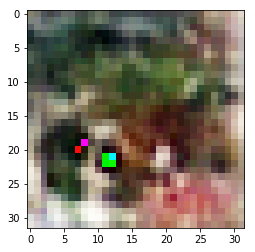

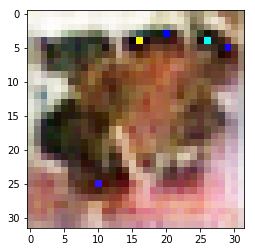

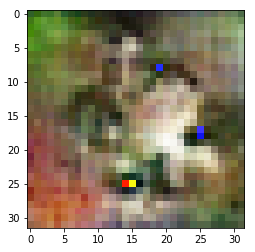

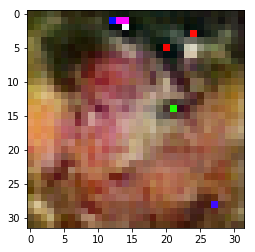

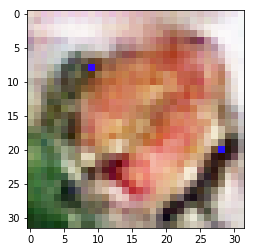

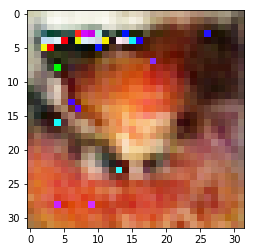

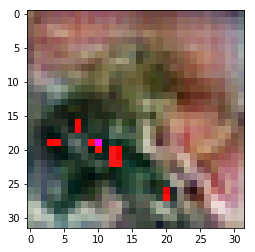

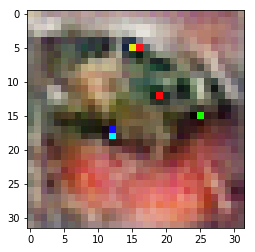

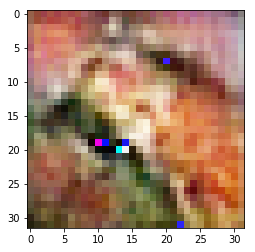

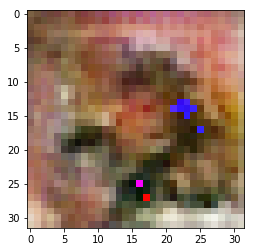

In [7]:
import matplotlib.pyplot as plt

# sample random points in the latent space（在潜在空间中采样随机点）
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images（将这些点解码为虚假图像）
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Froggy with some pixellated artifacts.

## 小结

* GAN 由一个生成器网络和一个判别器网络组成。判别器的训练目的是能够区分生成器的输出与来自训练集的真实图像，生成器的训练目的是欺骗判别器。值得注意的是，生成器从未直接见过训练集中的图像，它所知道的关于数据的信息都来自于判别器。
* GAN 很难训练，因为训练 GAN 是一个动态过程，而不是具有固定损失的简单梯度下降过程。想要正确地训练 GAN，需要使用一些启发式技巧，还需要大量的调节。
* GAN 可能会生成非常逼真的图像。但与 VAE 不同，GAN 学习的潜在空间没有整齐的连续结构，因此可能不适用于某些实际应用，比如通过潜在空间概念向量进行图像编辑。
